# Описание задачи
## В задачи пректа входит:
- Нахождение данных для обученяи модели: парсинг и/или иные источники;
- Предобработка полученных данных
- Создание новых признаков с использованием полученных данных;
- Отбор признаков;
- Отбор моделей;
- Обучение и тестирование отобранных моделей на отобранных признаках;
- Подбор макропараметров модели на отобранных признаках;
- Получение предсказанных моделью значений, подготовка и отправка submission

# Импорт библиотек, установка параметров, определение функций
## Импорт бибилиотек

In [94]:
import pandas as pd
import numpy as np
import json 
import seaborn as sns

from datetime import datetime
from datetime import date

from pprint import pprint

import warnings
import os

## Установка параметров

In [2]:
%pylab inline

warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 70)    # выведем больше строк
pd.set_option('display.max_columns', 30) # выведем больше колонок

# альтернативные пути для kaggle и локальный (НЕ ЗАБЫВАТЬ МЕНЯТЬ!)
path = './Project_5_data/'
# path = '/kaggle/input/.....'

# фиксация randomstate
RANDOM_SEED = 42

Populating the interactive namespace from numpy and matplotlib


C:\Users\Samsung\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Определение функций

In [3]:
def describe_df(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).drop(index=['mean','std','50%']).T 
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN_prop'] = round(df.isna().sum()/len(df),3)
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.top = [str(x)[:30] for x in df.mode(axis=0).iloc[0]]

    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    
    return desc

def train_opt_num(config):
    if config == config:
        decoded_config = json.loads(config.replace("'",'"'))
        options = [decoded_config[opt_cat] for opt_cat in decoded_config]
        options.append([])
        options = sum(options)
    else:
        options = []
    return len(options)    

def test_opt_num(config):
    if config == config:
        decoded_config = json.loads(config)
    else:
        decoded_config = {}         
    return len(decoded_config)

def unification_train(train):
    '''
    Приводит вид/формат данных в train к виду/формату в test
    
    
    '''
    df = train.copy()
    
    fuelType_unification = {
    'бензин':'бензин','дизель': 'дизель','бензин, газобаллонное оборудование': 'бензин','гибрид': 'гибрид',
    'дизель, газобаллонное оборудование': 'дизель','гибрид, газобаллонное оборудование': 'гибрид','газ': 'газ',
    'газ, газобаллонное оборудование': 'газ'}
    
    model_unification = {
    'C-HR':'C_HR', 'PRIUS_V_(+)': 'PRIUSPLUS','RAV4': 'RAV_4','105,_120': '100_SERIES','A6_ALLROAD': 'ALLROAD',
    'E-TRON': 'E_TRON','RS3': 'RS_3','RS4': 'RS_4','RS5': 'RS_5','RS6': 'RS_6','RS7': 'RS_7',
    'RSQ3': 'RS_Q3','CR-V': 'CR_V','CR-X': 'CR_X','CR-Z': 'CR_Z','FR-V': 'FR_V','HR-V': 'HR_V',
    'N-BOX': 'N_BOX','N-WGN': 'N_WGN','ODYSSEY_(NORTH_AMERICA)': 'ODYSSEY_NA','STEPWGN': 'STEPWAGON',
    'V40_CROSS_COUNTRY': 'V40_CC','02_(E10)': '02','1_СЕРИИ': '1ER','2_СЕРИИ': '2ER',
    '2_СЕРИИ_ACTIVE_TOURER': '2ACTIVETOURER','2_СЕРИИ_GRAN_TOURER': '2GRANDTOURER','3_СЕРИИ': '3ER',
    '4_СЕРИИ': '4','5_СЕРИИ': '5ER','6_СЕРИИ': '6ER','7_СЕРИИ': '7ER','8_СЕРИИ': '8ER','Z3_M': 'Z3M',
    'CARAVAN': 'CARAVAN_COACH','CLIPPER_RIO': 'CLIPPER','GT-R': 'GT_R','NAVARA_(FRONTIER)': 'NAVARA',
    'QASHQAI+2': 'QASHQAI_PLUS_2',"R'NESSA": 'RNESSA','X-TRAIL': 'X_TRAIL',    'G': 'G35','190_(W201)': 'W201',
    '220_(W187)': 'W187','A-КЛАСС': 'A_KLASSE','A-КЛАСС_AMG': 'A_KLASSE_AMG','B-КЛАСС': 'B_KLASSE',
    'C-КЛАСС': 'C_KLASSE','C-КЛАСС_AMG': 'C_KLASSE_AMG','CL-КЛАСС': 'CL_KLASSE','CL-КЛАСС_AMG': 'CL_KLASSE_AMG',
    'CLA': 'CLA_KLASSE','CLA_AMG': 'CLA_KLASSE_AMG','CLC-КЛАСС': 'CLC_KLASSE','CLK-КЛАСС': 'CLK_KLASSE',
    'CLS': 'CLS_KLASSE','CLS_AMG': 'CLS_KLASSE_AMG','E-КЛАСС': 'E_KLASSE','E-КЛАСС_AMG': 'E_KLASSE_AMG',
    'G-КЛАСС': 'G_KLASSE','G-КЛАСС_AMG': 'G_KLASSE_AMG','GL-КЛАСС': 'GL_KLASSE','GL-КЛАСС_AMG': 'GL_KLASSE_AMG',
    'GLA': 'GLA_CLASS','GLA_AMG': 'GLA_CLASS_AMG','GLB': 'GLB_KLASSE','GLC': 'GLC_KLASSE','GLC_AMG': 'GLC_KLASSE_AMG',
    'GLE': 'GLE_KLASSE','GLE_AMG': 'GLE_KLASSE_AMG','GLE_COUPE': 'GLE_KLASSE_COUPE',
    'GLE_COUPE_AMG': 'GLE_KLASSE_COUPE_AMG','GLK-КЛАСС': 'GLK_KLASSE','GLS': 'GLS_KLASSE',
    'GLS_AMG': 'GLS_KLASSE_AMG','M-КЛАСС': 'M_KLASSE','M-КЛАСС_AMG': 'M_KLASSE_AMG','MAYBACH_S-КЛАСС': 'S_CLASS_MAYBACH',
    'R-КЛАСС': 'R_KLASSE','S-КЛАСС': 'S_KLASSE','S-КЛАСС_AMG': 'S_KLASSE_AMG','SL-КЛАСС': 'SL_KLASSE',
    'SL-КЛАСС_AMG': 'SL_KLASSE_AMG','SLK-КЛАСС': 'SLK_KLASSE','SLR_MCLAREN': 'SLR_KLASSE','V-КЛАСС': 'V_KLASSE',
    'X-КЛАСС': 'X_KLASSE','DELICA_D:2': 'DELICA_D2','DELICA_D:5': 'DELICA_D_5','I-MIEV': 'I_MIEV'}
    
    df.brand = df.brand.apply(lambda x: 'MERCEDES' if x=='MERCEDES-BENZ' else x)
    df.fuelType = df.fuelType.str.lower().map(fuelType_unification)
    df.mileage = df.mileage.apply(lambda x: int(x) if x==x else 0)
    
    df.model_name = df.model_name.str.replace(' ','_',regex=False).str.upper()
    df.model_name = [new if new==new else old for new,old in zip(df.model_name.map(model_unification),df.model_name)]
    
    df.productionDate = df.productionDate.apply(lambda x: int(x) if x==x else 0)
      
    return df

def unification_test(test):
    df = test.copy()
    
    df.engineDisplacement = df.engineDisplacement.apply(lambda x: float(x[:-4]) if x[:-4] else np.NaN)
    df.enginePower = df.enginePower.str[:-4].astype(int)
    
    return df


def cat_visualisation():
    pass

def num_visualisation():
    pass

# Изучение  валидационных данных 

Что бы понимать какие признаки нам нужны для обучения модели нам необходимо узнать какие признаки описывают наблюдения, для которых мы должны предсказать целевую переменную.  

Поэтому для начала исследуем набор данных эти наблюдения описывающие.

In [4]:
df_test = pd.read_csv(f'{path}test.csv')

### Общий обзор

In [5]:
df_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Columns: 32 entries, bodyType to Таможня
dtypes: int64(6), object(26)
memory usage: 8.5+ MB


In [6]:
describe_df(df_test)

,count,unique,top,freq,min,max,type,NaN_prop
bodyType,34686,24,седан,13147,NaN,NaN,<class 'str'>,0.000
brand,34686,12,BMW,4473,NaN,NaN,<class 'str'>,0.000
car_url,34686,34686,https://auto.ru/cars/used/sale,1,NaN,NaN,<class 'str'>,0.000
color,34686,16,чёрный,11010,NaN,NaN,<class 'str'>,0.000
complectation_dict,6418,2364,"{""id"":""4562904"",""name"":""Elegan",51,NaN,NaN,<class 'float'>,0.815
description,34686,31732,Выгода до 82 000 руб. при обме,264,NaN,NaN,<class 'str'>,0.000
engineDisplacement,34686,55,2.0 LTR,7391,NaN,NaN,<class 'str'>,0.000
enginePower,34686,315,249 N12,1708,NaN,NaN,<class 'str'>,0.000
equipment_dict,24690,23705,"{""leather"":true}",108,NaN,NaN,<class 'str'>,0.288
fuelType,34686,5,бензин,28601,NaN,NaN,<class 'str'>,0.000


Всего в исходном валидационном датасете 32 колонки с разными типами данных (6 int, 26 object) и разыми типами признаков:   
-бинарные (в колонках `vendor`, `ПТС`, `Руль`);   
-категориальные (например в колонках `bodyType`, `brand`, `color`, `Владельцы`);  
-количественные (например в `enginePower` или `mileage`).  

Некоторын колонки содержат словари или длинные строки, содержащие сразу несколько признаков. 

Колонка `brand` содержит 12 уникальных значений. Это позволяет нам существенно сократить обьем работы по парсингу, ведь релевантными будут только данные по этим 12 брендам, поэтому только по ним и будем собирать информацию.

Колонка `car_url` содержит ссылки на обьявления о продаже авто на сайте ***auto.ru***, что как бы намекает, что валидационный набор спарсен с сайта ***auto.ru***. Воспользуемся этим же источником.

Три колонки  `priceCurrency`, `Состояние` и `Таможня` содержат только одно уникальное хначение, они ненесут никакой информации, поэтому исключим их из рассмотрения.  
  
Теперь следует ознакомиться с  каждым признак/колонку более детально. Это позволит нам понять в каком виде/формате содержится информация в колонках и соответсвенно сформировать набор данных для обучения в том же виде/формате. Так же детальное ознакомлене позволит окончательно определится с необходимость включения информации из колонок в рассмотрение моделью. В случае включения данных в рассмотрение моделью, провеем EDA. 

### Детальное ознакомление
### bodyType

In [7]:
df_test.bodyType.sample(3)

29702                седан
11664    внедорожник 5 дв.
14642    внедорожник 5 дв.
Name: bodyType, dtype: object

In [8]:
df_test.bodyType.unique()

array(['лифтбек', 'внедорожник 5 дв.', 'хэтчбек 5 дв.', 'седан',
       'компактвэн', 'универсал 5 дв.', 'пикап одинарная кабина',
       'хэтчбек 3 дв.', 'купе', 'кабриолет', 'минивэн',
       'пикап двойная кабина', 'внедорожник 3 дв.', 'родстер', 'микровэн',
       'седан 2 дв.', 'купе-хардтоп', 'фастбек', 'тарга',
       'внедорожник открытый', 'лимузин', 'пикап полуторная кабина',
       'седан-хардтоп', 'фургон'], dtype=object)

Колонка содержит наименование типа кузова в виде строковой величины. Принимается в пассмоттение. 

### brand

In [9]:
df_test.brand.sample(3)

7091     VOLVO
995      SKODA
30275     AUDI
Name: brand, dtype: object

In [10]:
df_test.brand.unique()

array(['SKODA', 'AUDI', 'HONDA', 'VOLVO', 'BMW', 'NISSAN', 'INFINITI',
       'MERCEDES', 'TOYOTA', 'LEXUS', 'VOLKSWAGEN', 'MITSUBISHI'],
      dtype=object)

Колонка содержит наименование марки в виде строковой величины. Принимается в рассмотрение.

### car_url

In [11]:
df_test.car_url.sample(5)

33130    https://auto.ru/cars/used/sale/infiniti/g35/11...
25545    https://auto.ru/cars/used/sale/volkswagen/golf...
6881     https://auto.ru/cars/used/sale/volvo/xc70/1101...
30321    https://auto.ru/cars/used/sale/audi/a6/1100966...
29505    https://auto.ru/cars/used/sale/bmw/5er/1100636...
Name: car_url, dtype: object

В этой колонке содержаться ссылки на обьявления о продаже, послужившие источником при парсинге `test`. В настоящий момент скорее всего ссылки уже не активны, потому колокна будет исключена из рассмотрения моделью. Но нформация в ней содержащаяся позволит нам проверить не попадают ли в тренировочный набор данных наблюдения из валидационного. 

### color

In [12]:
df_test.color.sample(3)

10400      белый
11606      синий
4061     красный
Name: color, dtype: object

In [13]:
df_test.color.unique()

array(['синий', 'чёрный', 'серый', 'коричневый', 'белый', 'пурпурный',
       'бежевый', 'серебристый', 'красный', 'зелёный', 'жёлтый',
       'голубой', 'оранжевый', 'фиолетовый', 'золотистый', 'розовый'],
      dtype=object)

Колонка содержит название цвета кузова, принимется в рассмотрение. 

### complectation_dict

In [14]:
df_test.complectation_dict.head(3)

0                                                  NaN
1                                                  NaN
2    {"id":"20026336","name":"Ambition","available_...
Name: complectation_dict, dtype: object

In [15]:
df_test.complectation_dict.loc[2]

'{"id":"20026336","name":"Ambition","available_options":["heated-wash-system","airbag-passenger","lock","door-sill-panel","electro-mirrors","mirrors-heat","cooling-box","computer","seat-transformation","wheel-power","fabric-seats","airbag-side","abs","wheel-leather","climate-control-1","esp","adaptive-light","audiopreparation","ashtray-and-cigarette-lighter","front-centre-armrest","electro-window-back","16-inch-wheels","body-mouldings","condition","airbag-driver","isofix","aux","electro-window-front","light-sensor","hcc","ptf","rain-sensor","tyre-pressure","audiosystem-cd","front-seats-heat","wheel-configuration2","wheel-configuration1","immo","12v-socket","third-rear-headrest"]}'

Колонка содержит словарь стандартной комплектации с наименованием комплектации и списком обрудования (зачастую стандартного, имеющегося в любом автомобиле, например "12v-socket" или "lock") входящим в такую комплектацию. Доля пррпусков (свыше 0.8), перечисление оборудования присутсвуюшегов любом авто данной марки и модели и наличие колонки `equipment_dict` с гораздо меньшим количеством пропусков позволяет исключить колонку из рассмотрения.

### description

In [16]:
print(df_test.description[0])

Все автомобили, представленные в продаже, проходят тщательную проверку по более 40 параметрам. Предоставляем гарантию юридической чистоты, а так же год технической гарантии на двигатель и КПП. Бесплатный тест-драйв. Возможно оформление автомобиля в кредит!

Преимущества автокредитования:
— Первоначальный взнос от 0%;
— Более 30 кредитных программ;
— Процентная ставка от 6% годовых;
— Срок кредита от 6 месяцев до 7 лет;
— Оформление кредита по двум документам;
— Досрочное погашение без штрафов и комиссий;
— Сумма кредита до 2 млн рублей;
— Оформление КАСКО – по желанию;
— Без справок и поручителей.

Сотрудничаем с 12 аккредитованными и сертифицированными банками РФ, среднее время ожидания решения банка 20–30 минут.

При покупке автомобиля по программе «Trade-in – выгодный обмен» или в кредит, получите дополнительную скидку до 80 000 рублей на данный автомобиль!

Записаться на тест-драйв, а так же получить подробную информацию можно у специалистов автоцентра по указанному номеру телефона

В колонке содержится текст, относящийся скорее к продавцу, чем к конкретному автомобилю. Поэтому на данном этапе ( и вероятно вообще) колонка исключается из рассмотрения.

### engineDisplacement

In [17]:
df_test.engineDisplacement.unique()

array(['1.2 LTR', '1.6 LTR', '1.8 LTR', '2.0 LTR', '1.4 LTR', '1.3 LTR',
       '1.0 LTR', '3.6 LTR', '1.5 LTR', '1.9 LTR', '2.8 LTR', '1.1 LTR',
       '2.5 LTR', '4.2 LTR', '3.0 LTR', '4.0 LTR', '5.9 LTR', '2.7 LTR',
       '3.1 LTR', '2.4 LTR', '5.2 LTR', '3.2 LTR', '4.1 LTR', '6.3 LTR',
       '2.3 LTR', '6.0 LTR', '2.2 LTR', '3.7 LTR', '2.9 LTR', '5.0 LTR',
       '3.3 LTR', '2.1 LTR', '2.6 LTR', ' LTR', '3.5 LTR', '1.7 LTR',
       '0.7 LTR', '4.4 LTR', '4.8 LTR', '5.4 LTR', '6.6 LTR', '4.9 LTR',
       '3.8 LTR', '3.4 LTR', '3.9 LTR', '4.6 LTR', '5.6 LTR', '4.5 LTR',
       '5.5 LTR', '6.2 LTR', '4.7 LTR', '4.3 LTR', '5.8 LTR', '5.3 LTR',
       '5.7 LTR'], dtype=object)

In [18]:
df_test.engineDisplacement.value_counts()[' LTR']

55

Колонка содержит обьем двигателя, принимется в рассмотрение. Следует отметить наличие скрытых пропусков (55 стрк `' LTR'`)

### enginePower

In [19]:
df_test.enginePower.unique()[:100]

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

Колонка содержит мощность двигателя, принмается в рассмотрение.

### equipment_dict

In [20]:
df_test.equipment_dict.sample(5)

33197    {"cruise-control":true,"asr":true,"aux":true,"...
24536    {"asr":true,"computer":true,"abs":true,"roof-r...
5395     {"engine-proof":true,"cruise-control":true,"ti...
1876     {"engine-proof":true,"tinted-glass":true,"esp"...
33662    {"cruise-control":true,"asr":true,"esp":true,"...
Name: equipment_dict, dtype: object

In [21]:
df_test.equipment_dict.apply(lambda x: json.loads(x) if x==x else x).sample(5)

33035    {'alloy-wheel-disks': True, 'velvet-seats': Tr...
2470     {'cruise-control': True, 'asr': True, 'tinted-...
13719    {'airbag-passenger': True, 'condition': True, ...
24498                          {'ptf': True, 'lock': True}
6143     {'engine-proof': True, 'airbag-driver': True, ...
Name: equipment_dict, dtype: object

В колонке много пропусков (почти 29%), не пропущенные значения представляют собой текстово епредсьавление словаря с перечислением оснащения автомобиля. В рассмотрнеие моделью будет приняты те пункты оснащения, что будут пересекаться с пунктами оснащения обучающего набора данных.

### fuelType

In [22]:
df_test.fuelType.unique()

array(['бензин', 'дизель', 'гибрид', 'электро', 'газ'], dtype=object)

Колонка содержит тип топлива. Принимается врассмотрнеи.

### image

In [23]:
df_test.image.sample(5)

16262    https://avatars.mds.yandex.net/get-autoru-vos/...
16637    https://autoru.naydex.net/ESooa9149/468b9eoMem...
11744    https://autoru.naydex.net/G87gDZg56/28c7a8vqVE...
32431    https://autoru.naydex.net/1xsMU7627/eea2057RFg...
31479    https://avatars.mds.yandex.net/get-autoru-vos/...
Name: image, dtype: object

Колонка содержит ссылки на фото или аватар авто, исключается из рассмотрения.

### mileage

In [24]:
df_test.mileage.sample(5)

34350    248600
17107     77290
15816    125000
23373    115620
4882     112000
Name: mileage, dtype: int64

Колонка содержит пробег авто, принмается в рассмотрениею

### modelDate

In [25]:
df_test.modelDate.unique()

array([2013, 2017, 2008, 2009, 2016, 2012, 2015, 2010, 2006, 2000, 2007,
       1994, 2004, 1999, 2005, 1976, 2001, 1969, 1996, 1998, 1989, 1934,
       2014, 2011, 2018, 1986, 1997, 1990, 2019, 2002, 1991, 1987, 1980,
       1982, 1938, 1988, 2003, 1983, 1978, 1979, 1984, 1992, 1995, 1993,
       1985, 1974, 1966, 1977, 1981, 1972, 1968, 1975, 1949, 1937, 1936,
       1973, 1959, 1958, 2020, 1965, 1971, 1904, 1963, 1955, 1951, 1960],
      dtype=int64)

Колонка содержит год начала выпуска модели, принимется в рассмотрние.

### model_info

In [26]:
df_test.model_info.sample(5)

15506    {"code":"E_KLASSE","name":"E-Класс","ru_name":...
28107    {"code":"COLT","name":"Colt","ru_name":"Кольт"...
12743    {"code":"TERRANO","name":"Terrano","ru_name":"...
30422    {"code":"TIGUAN","name":"Tiguan","ru_name":"Ти...
29903    {"code":"Q7","name":"Q7","ru_name":"Ку7","morp...
Name: model_info, dtype: object

Колонка содержит наименование модели в трех вариантах. Учитывая наличие `model_name` колонка исключается из рассмотрения

### model_name

In [27]:
df_test.model_name.sample(5)

31788      VITO
26153      POLO
23870     JETTA
28541    LANCER
9795        5ER
Name: model_name, dtype: object

Наименование модели. Принимается к рассмотрению.

### name

In [28]:
df_test.name.sample(5)

7576       520i 2.0 AT (184 л.с.)
33847       3.1 AT (255 л.с.) 4WD
7619       520i 2.0 MT (150 л.с.)
4991           2.0 CVT (170 л.с.)
3265     2.0hyb AT (211 л.с.) 4WD
Name: name, dtype: object

Колонка содержит расширение названия модели, указывающее на обьем двигателя и тип привода. Поскольку эта информация уже получена из других колонок, эта в рассмотрнеие не принимается

### numberOfDoors

In [29]:
df_test.numberOfDoors.unique()

array([5, 4, 2, 3, 0], dtype=int64)

Колонка содержит числовое представление количества дверей, принимется в рассмотрение.

### parsing_unixtime

Колонка судя по названию содержит время сбора информации в валидационный набор данных. Непосредственно для обученяи информация не нужна. Но время сбора поможет внести поправку на изменение коньюктуры(курс валюты и т.д.). 
Посмотрим на диапазон `parsing_unixtime`:

In [30]:
# datetime.utcfromtimestamp(df_test.parsing_unixtime.min())

In [31]:
# datetime.utcfromtimestamp(df_test.parsing_unixtime.max())

In [32]:
date.fromtimestamp(df_test.parsing_unixtime.min()),date.fromtimestamp(df_test.parsing_unixtime.max())

(datetime.date(2020, 10, 19), datetime.date(2020, 10, 26))

Как видим парсинг произведен с 19 по 26 октября 20-го года

### productionDate

In [33]:
df_test.productionDate.unique()

array([2014, 2017, 2012, 2011, 2019, 2018, 2010, 2020, 2016, 2013, 2006,
       2007, 2015, 2005, 2008, 2009, 1997, 2004, 2002, 1987, 2003, 2001,
       1976, 2000, 1998, 1995, 1999, 1993, 1939, 1996, 1984, 1990, 1991,
       1992, 1989, 1982, 1985, 1994, 1938, 1981, 1988, 1983, 1980, 1986,
       1978, 1970, 1979, 1977, 1972, 1975, 1969, 1950, 1953, 1949, 1937,
       1959, 1968, 1936, 1904, 1974, 1967, 1961, 1960, 1965, 1963, 1957,
       1952, 1973, 1948], dtype=int64)

Год производства автомобиля ( наверное наряду с моделью автомобиля самы значимый признак). Принмается в рассмотрнеие.

### sell_id

In [34]:
df_test.car_url[1]

'https://auto.ru/cars/used/sale/skoda/octavia/1100549428-595cadf2/'

In [35]:
df_test.sell_id[1]

1100549428

In [36]:
df_test.sell_id.unique()

array([1100575026, 1100549428, 1100658222, ..., 1101364889, 1101362518,
       1101256068], dtype=int64)

Колонка содержит ***id*** обьявления. Как непосредственный признак не интересен, в рассмотрение моделью не принимается. Но если предположить, что ***id*** отражает хронологический порядок появления обьявления, то, например, можно попробовать при "тонкой настройке" модели придать более новым обьявлениям больший вес при обучении.

### super_gen

In [37]:
df_test.super_gen[0]

'{"id":"10373605","displacement":1197,"engine_type":"GASOLINE","gear_type":"FORWARD_CONTROL","transmission":"ROBOT","power":105,"power_kvt":77,"human_name":"1.2 AMT (105 л.с.)","acceleration":10.5,"clearance_min":155,"fuel_rate":5}'

Колонка содержит ***id*** и параметры автомобиля, которые либо являются по сути атрибутами модели (например у всех автомобилей одной модели одной модификации одинаковый клиренс) либо уже известны нам из других колонок (например тип трансмиссии). В рассмотрнеи не принимается.

### vehicleConfiguration

In [38]:
df_test.vehicleConfiguration.sample(5)

31546     ALLROAD_5_DOORS AUTOMATIC 3.5
34040       WAGON_5_DOORS AUTOMATIC 1.6
4715                SEDAN AUTOMATIC 2.8
31592    HATCHBACK_5_DOORS VARIATOR 2.0
10703     ALLROAD_5_DOORS AUTOMATIC 2.0
Name: vehicleConfiguration, dtype: object

Содержит информацию о типе кузова, типе трансмиссии обьеме двигателя количестве дверей. Эта информация доступна в других колонках, поэтому `vehicleConfiguration` в рассмотрение не принимется 

### vehicleTransmission

In [39]:
df_test.vehicleTransmission.unique()

array(['роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

Колонка содержит в тестовом виде тип трансмиссии. Принимается в рассмотрение.

### vendor

In [40]:
df_test.vendor.unique()

array(['EUROPEAN', 'JAPANESE'], dtype=object)

In [41]:
df_test.groupby('vendor').brand.unique()

vendor
EUROPEAN      [SKODA, AUDI, VOLVO, BMW, MERCEDES, VOLKSWAGEN]
JAPANESE    [HONDA, NISSAN, INFINITI, TOYOTA, LEXUS, MITSU...
Name: brand, dtype: object

Как видим колонка содержит обобщающий признак - принадлежность марки к европейским либо японским. Как подсказывает опыт автовладельца динамика падения цены от срока владения у этих двух групп различается (японцы обычно дешевеют медленнее, особенно Toyota). Посчитаем признак полезным, примем в рассмотрение моделью.

### Владельцы

In [42]:
df_test.Владельцы.unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

Колонка содержит в текстовом виде три категории количества владельцев авто. Примем в рассмотрение

### Владение

In [43]:
df_test.Владение.unique()[:20]

array([nan, '3 года и 2 месяца', '11 месяцев', '4 года и 1 месяц',
       '2 года и 4 месяца', '1 месяц', '3 года и 10 месяцев',
       '2 года и 6 месяцев', '6 лет и 4 месяца', '2 месяца', '4 месяца',
       '1 год и 10 месяцев', '2 года и 7 месяцев', '7 лет и 11 месяцев',
       '7 лет и 5 месяцев', '1 год и 11 месяцев', '2 года и 1 месяц',
       '7 лет', '4 года и 2 месяца', '2 года и 8 месяцев'], dtype=object)

Колонка содержит время прошедшее с момента выпуска авто. Очевидно линейно зависит о даты выпуска автомобиля - исключается из рассмотрения.

### ПТС

In [44]:
df_test.ПТС.unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

Колонка содержит (если значение не nan) категорию ПТС. Принимается в рассмотрение.

### Привод

In [45]:
df_test.Привод.unique()

array(['передний', 'полный', 'задний'], dtype=object)

Колонка содержит категорию привода. Принимается в расмотрние.

### Руль

In [46]:
df_test.Руль.unique()

array(['Левый', 'Правый'], dtype=object)

Колонка содержит категрию право- или левосторонности управления . В рассмотрение.
 ## Колонки подлежащие рассмотрению моделью
Итого из валидационного набора данных, содержащихся в `df_test`,  для обработки данных и последующего построения модели будем спользовать информацию из следующих колонок:

In [47]:
columns_to_handle = ['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement', 'enginePower', 
                      'equipment_dict','fuelType', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 
                      'productionDate', 'sell_id', 'vehicleTransmission', 'vendor', 
                      'Владельцы', 'ПТС', 'Привод', 'Руль']
useful_columns = ['parsing_unixtime']

In [48]:
test = df_test[columns_to_handle]

## Унификация test и train

In [49]:
train = pd.read_csv(f'{path}all_marks.csv')

In [50]:
train = unification_train(train)
test = unification_test(test)

In [51]:
train.equipment_dict = train.equipment_dict.apply(train_opt_num);
test.equipment_dict = test.equipment_dict.apply(test_opt_num);

## Проверка на отсутсвие в train наблюдений из test
Проверим - не попали ли в набор данных для обучения обьявления из валидационного набора.  
Получим sell_id содержащиеся в них обоих и посмтрим на эти sell_id:

In [52]:
common_id = set(test.sell_id) & set(train.sell_id)

len(common_id)

3313

Как видим такиx обьявлений-дублей оказалось 3313. Придется их удалить из обучабщих данных.  
Замечу, что помимо проблемы с переобучением это также улучшит качествообучающего набора - ведь если обьвление активно более полугода, то с большой вероятностью оно не адекватно состоянию рынка

In [53]:
mask = [id in common_id for id in train.sell_id]
index_to_drop = train.index[mask]
train.drop(index=index_to_drop,inplace=True)

## Оработка пропусков
Займеся пропусками в test и train

In [54]:
electric_cars = ['E_TRON', 'I3', 'LEAF','EQC', 'COMS','I_MIEV','E6', 
 'SONG_EV', 'BOLT', 'SOUL_EV','TAYCAN', 
 'MODEL_3', 'MODEL_S','MODEL_X', 'MODEL_Y']
gibrid_cars = ['HYUNDAI IONIQ']

train.fuelType[[x in electric_cars   for x in train.model_name]] = 'электро'
train.fuelType[[x in gibrid_cars   for x in train.model_name]] = 'гибрид'

In [55]:
mask = train.drop(columns = ['numberOfDoors','modelDate','engineDisplacement','enginePower']).isna().any(axis=1) 
index_to_drop = train.index[mask]

In [56]:
train.drop(index=index_to_drop,inplace=True)

In [57]:
train.isna().sum()

bodyType                   0
brand                      0
car_url                    0
color                      0
engineDisplacement        89
enginePower               89
equipment_dict             0
fuelType                   0
mileage                    0
modelDate               6426
model_name                 0
numberOfDoors          29538
productionDate             0
sell_id                    0
vehicleTransmission        0
vendor                     0
Владельцы                  0
ПТС                        0
Привод                     0
Руль                       0
offerprice                 0
dtype: int64

In [58]:
test.drop(index=10412,inplace=True)

In [59]:
test.isna().sum()

bodyType                0
brand                   0
car_url                 0
color                   0
engineDisplacement     55
enginePower             0
equipment_dict          0
fuelType                0
mileage                 0
modelDate               0
model_name              0
numberOfDoors           0
productionDate          0
sell_id                 0
vehicleTransmission     0
vendor                  0
Владельцы               0
ПТС                     0
Привод                  0
Руль                    0
dtype: int64

## Объединение test и train

In [60]:
train['sample'] = 1  # помечаем где у нас трейн
test['sample'] = 0   # помечаем где у нас тест
test['offerprice'] = np.NaN  # в тесте нет значения price -  пока просто заполняем np.NaN

train_reduced = train.loc[train.brand=='BMW']

data = test.append(train, sort=False).reset_index(drop=True) # объединяем

# УБРАТЬ КАР УРЛ

In [97]:
tst_brands = test.brand.unique()
brand_mask = [x in tst_brands for x in trn.brand]
trn[brand_mask]

## EDA test и train

Разделим признаки на количественные num_cols , категориальные cat_cols и бинарные bin_cols. К бинарным, очевидно, отнесем признаки с двумя уникальными значениями.
Категориальными признаками будем считать признаки с количеством уникальных значений от 3 до 9
Порогом для количественного признака будет наличие более чем 10 уникальных значений.
Временной ряд рассмотрим отдельно.

In [67]:
num_uniq = data.nunique()
time_col = pd.Index(['sell_id'])
bin_cols = data.columns[num_uniq==2]
cat_cols = data.columns[(num_uniq>2) & (num_uniq<28)].append(pd.Index(['model_name','brand'])) 
num_cols = data.columns[num_uniq>=28].drop(time_col).drop(['model_name','brand'])

In [142]:
num_uniq

bodyType                  27
brand                    132
car_url                93540
color                     16
engineDisplacement        70
enginePower              425
equipment_dict           117
fuelType                   5
mileage                28288
modelDate                 74
model_name              1449
numberOfDoors              5
productionDate            89
sell_id                93540
vehicleTransmission        4
vendor                     3
Владельцы                  3
ПТС                        2
Привод                     3
Руль                       2
sample                     2
offerprice              4599
dtype: int64

количественные

In [69]:
num_cols

Index(['car_url', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'mileage', 'modelDate', 'productionDate', 'offerprice'],
      dtype='object')

In [140]:
def num_visualisation(column,df,logflag=False):
    '''
    Визулизация распределения количественного ризнака:
        - гистограмма распределения в обучающей выборке при двух значениях целевой переменной
        - boxplot распределения в обучающей выборке при двух значениях целевой переменной
        - гистограмма рапсределения в обучающей и валидационной выборке
        - boxplot рапсределения в обучающей и валидационной выборке
    '''

    trn = df[df['sample']==1]
    tst = df[df['sample']==0]
    tst_brands = tst.brand.unique()
    brand_mask = [x in tst_brands for x in trn.brand]
    trn_ = trn[brand_mask]

    row_trn = trn[num_column]
    row_tst = tst[num_column]
    row_trn_ = trn_[num_column]

    if logflag: 
        row_trn = np.log(row_trn+1)
        row_tst = np.log(row_tst+1)
        row_trn_ = np.log(row_trn_+1)
    
    fig = plt.figure(figsize=(14,4))
#*******************************************************************
    ax1 = fig.add_axes([0, 0.4, 0.45, 1])
    plt.title('Распределение '+num_column+' в train (на всех марках) и в test' )
    row_trn.plot.hist(bins=50,density=True,alpha = 0.65)
    row_tst.plot.hist(bins=50,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax2 = fig.add_axes([0, 0, 0.45, 0.30]) 
    
    sns.boxplot(data = [row_trn,row_tst],orient='h',saturation = 0.5)

#*******************************************************************
    ax3 = fig.add_axes([0.55, 0.4, 0.45, 1])
    plt.title('Распределение '+num_column+' в train (только на марках из test) и в test' )
    row_trn_.plot.hist(bins=50,density=True,alpha = 0.65)
    row_tst.plot.hist(bins=50,density=True,alpha = 0.65)
    plt.legend(['train','test']) 
#*******************************************************************
    ax4 = fig.add_axes([0.55, 0, 0.45, 0.30]) 

    sns.boxplot(data = [row_trn_,row_tst],orient='h',saturation = 0.5)

In [170]:
def nums_visualisation(df,annotation=False):
    '''
    визуализация распределений количественных признаков: \n
        - гисторгамма распределения \n
        - boxplot распределения
    '''
    columns = df.columns
    cols_num = df.shape[1]

    fstr = '\033[1m{}\033[0m, '* (len(columns)-1) + '\033[1m{}\033[0m'
    if annotation: print(('Всего признаков этого типа {}.\nК ним относятся: ' + fstr).format(len(columns),*columns))
        
    indent = 0.05
    fig = plt.figure(figsize=(14,3))
    for i,col in enumerate(columns):
        row = df[col]
        min_diff = pd.Series(row.unique()).sort_values().diff().min()
        bins = min(int((row.max()-row.min()) /min_diff + 1),100)
        
        fig.add_axes([1/cols_num*i, 0.35, 1/cols_num-indent, 1])
        plt.title(col)
        row.plot.hist(bins=bins,density=True)
    
        fig.add_axes([1/cols_num*i, 0, 1/cols_num-indent, 0.2])
        sns.boxplot(x=row)

#     plt.tight_layout()


Всего признаков этого типа 7.
К ним относятся: engineDisplacement, enginePower, equipment_dict, mileage, modelDate, productionDate, offerprice


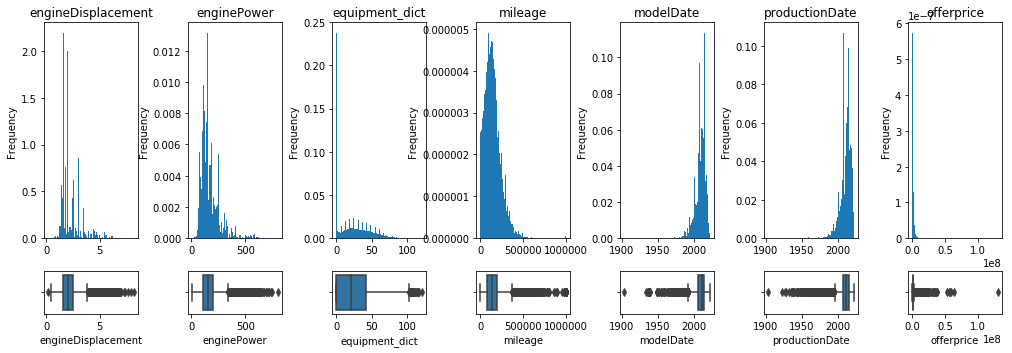

In [171]:
nums_visualisation(data[num_cols].drop(columns='car_url'), annotation=True)

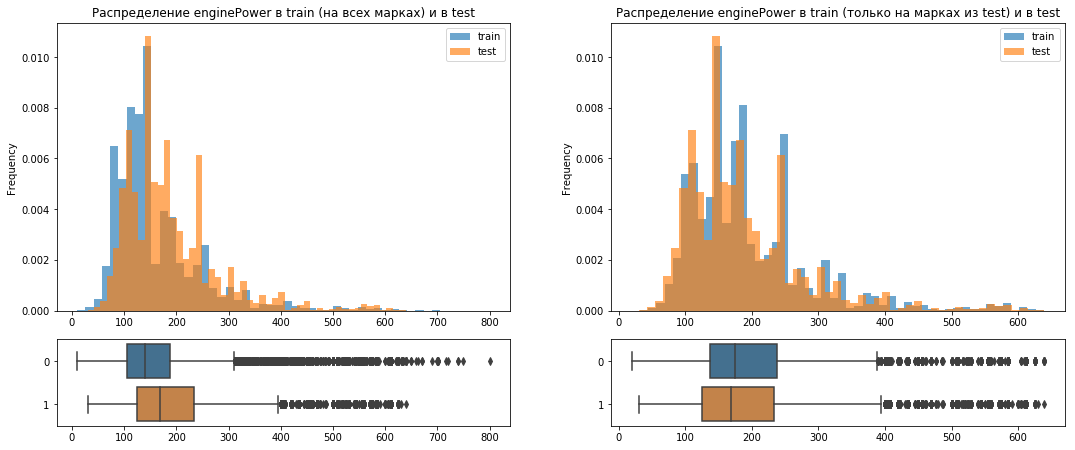

In [141]:
num_visualisation('mileage',data)

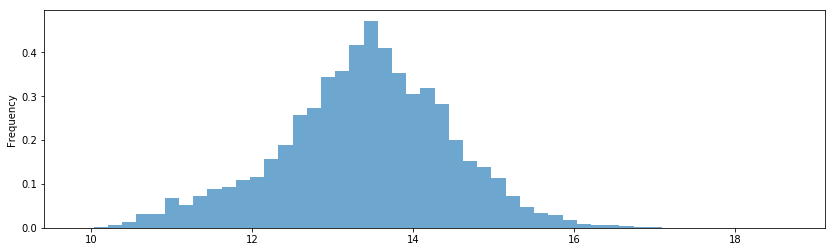

In [85]:
fig = plt.figure(figsize=(14,4))
row = data.offerprice
row = np.log(row+1)
row.plot.hist(bins=50,density=True,alpha = 0.65)

категориальные

In [63]:
cat_cols

Index(['bodyType', 'color', 'fuelType', 'numberOfDoors', 'vehicleTransmission',
       'vendor', 'Владельцы', 'Привод', 'model_name'],
      dtype='object')

бинарные

In [64]:
bin_cols

Index(['ПТС', 'Руль', 'sample'], dtype='object')

sell_id

In [65]:
time_col

Index(['sell_id'], dtype='object')

## ====================================================================

In [1]:
def df_describe(df):
    '''
    Вывод простой статистки DataFrame
    '''
    desc = df.describe(include='all',percentiles=[0.5]).T
    desc['type'] = [type(x) for x in df.iloc[0]]
    desc['NaN'] = df.isna().sum()
    desc.unique = df.nunique()
    desc.top = df.mode(axis=0).iloc[0]
    desc.freq = [df[col].value_counts().iloc[0] for col in  df.columns]
    return desc


## ====================================================================

## Предобработка

## Base-line

## Features construction

## Отбор признаков

## Подбор гиперпараметров

## ========================================================

# Подвал

In [ ]:
'''tt = df_test.complectation_dict[2]
ttt = json.loads(tt)
ttt['available_options']'''

In [60]:
'''tmp = pd.read_csv(f'{path}all_marks.csv')
tmp.columns =pd.Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'offerprice'],
      dtype='object')
tmp.to_csv(f'{path}all_marks.csv',index=False)

tmp = pd.read_csv(f'{path}extra_train.csv')
tmp.columns =pd.Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'offerprice'],
      dtype='object')
tmp.to_csv(f'{path}extra_train.csv',index=False)

tmp = pd.read_csv(f'{path}train.csv')
tmp.columns =pd.Index(['bodyType', 'brand', 'car_url', 'color', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'vehicleTransmission', 'vendor', 'Владельцы', 'ПТС', 'Привод', 'Руль',
       'offerprice'],
      dtype='object')
tmp.to_csv(f'{path}train.csv',index=False)''';

In [61]:
unification_test(test).head()

unification_train(train).head()

,bodyType,brand,car_url,color,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,model_name,numberOfDoors,productionDate,sell_id,vehicleTransmission,vendor,Владельцы,ПТС,Привод,Руль
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,1.2,105,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,OCTAVIA,5,2014,1100575026,роботизированная,EUROPEAN,3 или более,Оригинал,передний,Левый
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,1.6,110,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017,OCTAVIA,5,2017,1100549428,механическая,EUROPEAN,1 владелец,Оригинал,передний,Левый
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,1.8,152,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013,SUPERB,5,2014,1100658222,роботизированная,EUROPEAN,1 владелец,Оригинал,передний,Левый
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,1.6,110,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,95000,2013,OCTAVIA,5,2014,1100937408,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,1.8,152,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,58536,2008,OCTAVIA,5,2012,1101037972,автоматическая,EUROPEAN,1 владелец,Оригинал,передний,Левый


In [187]:
ttt = [['2'],['2']]
ttt.append([])

sum()

In [189]:
ttt

[['2'], ['2'], []]

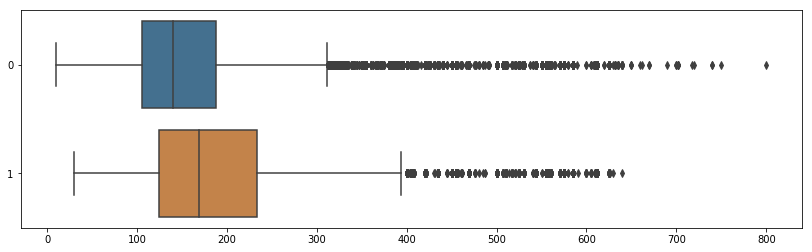

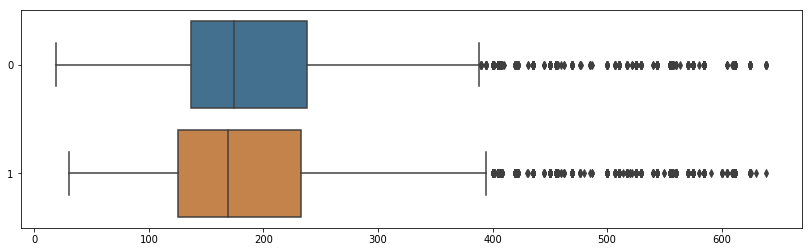

In [126]:
num_column = 'enginePower'
logflag = 0


trn = data[data['sample']==1]
tst = data[data['sample']==0]
trn_ = trn[brand_mask]

row_trn = trn[num_column]
row_tst = tst[num_column]
row_trn_ = trn_[num_column]

if logflag: 
    row_trn = np.log(row_trn+1)
    row_tst = np.log(row_tst+1)
    row_trn_ = np.log(row_trn_+1)

#*******************************************************************
fig = plt.figure(figsize=(14,4))
    
sns.boxplot(data = [row_trn,row_tst],orient='h',saturation = 0.5)
#*******************************************************************
fig = plt.figure(figsize=(14,4))

sns.boxplot(data = [row_trn_,row_tst],orient='h',saturation = 0.5)